In [64]:
%env MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij
import os
import base64
from mistralai import Mistral
import json
import pandas as pd
from typing import Union

# Load Mistral API key from environment variables
api_key = os.environ["MISTRAL_API_KEY"]

# Model specification
model = "mistral-large-latest"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

env: MISTRAL_API_KEY=ZL4LdkeCwsoIYcNx2aFDujTYgpwj2kij


In [108]:
def img_to_base64(image_path):
    """Input : image_path (str) : path to the image file
    Returns : image_base64 (str) : base64 encoded image"""
    
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()

    image_base64 = base64.b64encode(image_bytes).decode('utf-8')
    
    return image_base64

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

def list_clothes(image_base64): 
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"elements\": [{\"element\": \"some name of element1\", "
                    "\"color\": \"the color of element1\", "
                    "\"fit\": \"the fit of element1 (baggy, slim...)\", "
                    "\"price\": \"some number, estimated price of element1\", "
                    "\"context\": \"one word form this list : casual, formal, athletic, office-ready, streetwear, fashion, luxury\", "
                    "\"description\": \"a description of element1, emphasizing on the vibe of the piece\"}, "
                    "{\"element\": \"some name of element2\", ...}]}"
        },
        {
            "role": "user",
            "content": "Describe each clothing piece that this person is wearing using keywords."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

empty_element = {"element":None, "color":None, "fit":None, "price":None, "context":None, "description":None}

def recommend_from_image(image_base64, description=None, element = empty_element):
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"element\": \"a clothing piece that is not in the original image\", "
                    "\"color\": \"color of this piece\", "
                    "\"fit\": \"fit of this piexe (baggy, slim...)\", "
                    "\"price\": \"some number, estimated price of the piece\", "
                    "\"context\": \"one word from this list : casual, formal, athletic, office-ready, streetwear, fashion, luxury\", "
                    "\"description\": \"a short description of the recommended piece\"}"
        },
        {
            "role": "user",
            "content": "Describe a single clothing piece following the Requirements that fit the reference image."
                    "If not precised, keep in mind the color scheme and general vibe of the reference image."
        },
        {
            "role": "user",
            "content": f"Requirements: element: {element['element']}, color: {element['color']}, fit: {element['fit']}, price: {element['price']}, context: {element['context']}, description: {element['description']}."
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": f"data:image/jpeg;base64,{image_base64}"
                }
            ]
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="pixtral-12b-2409",
        messages=messages,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

def recommend_from_wardrobe(wardrobe, element = empty_element):
    # Define the messages for the chat API
    messages = [
        {
            "role": "system",
            "content": "Base your recommandation according to at least one of these rules: complementary colors, analogus colors, accent color, layering, proportion balance, accessories, mixing textures"
        },
        {
            "role": "system",
            "content": "Return the answer in a JSON object with the next structure: "
                    "{\"element\": \"a clothing piece that is not in the wardrobe\", "
                    "\"color\": \"color of this piece\", "
                    "\"fit\": \"fit of this piexe (baggy, slim...)\", "
                    "\"price\": \"some number, estimated price of the piece\", "
                    "\"context\": \"one word from this list : casual, formal, athletic, office-ready, streetwear, fashion, luxury\", "
                    "\"description\": \"a short description of the recommended piece and the rule you followed\"}"
        },
        {
            "role": "user",
            "content": "Describe a single clothing piece or accessory following the Requirements that fit in my wardrobe, while not already being in it."
        },
        {
            "role": "user",
            "content": f"Requirements: element: {element['element']}, color: {element['color']}, fit: {element['fit']}, price: {element['price']}, context: {element['context']}, description: {element['description']}."
        },
        {
            "role": "user",
            "content": f"I have these elements in my wardrobe: {(' '.join(wardrobe['description']))}."
        }
    ]

    # Call the Mistral API to complete the chat
    chat_response = client.chat.complete(
        model="mistral-large-latest",
        messages=messages,
        response_format={
            "type": "json_object",
        }
    )

    # Get the content of the response
    content = chat_response.choices[0].message.content
    
    return content

In [3]:
import matplotlib.pyplot as plt

,element,color,fit,price,context,description
0,Black T-shirt,Black,Standard,20-30 USD,Casual,"A simple black T-shirt, perfect for a casual a..."
1,Blue Long-sleeve Shirt,Blue,Standard,25-40 USD,Casual,A blue long-sleeve shirt layered over the T-sh...
2,Brown Corduroy Pants,Brown,Baggy,40-60 USD,Casual,"Brown corduroy pants with a baggy fit, ideal f..."
3,White Sneakers,White,Standard,50-70 USD,Casual,White sneakers that complete the casual look a...
4,Blue Baseball Cap,Blue,Standard,15-25 USD,Casual,A blue baseball cap that adds a sporty touch t...


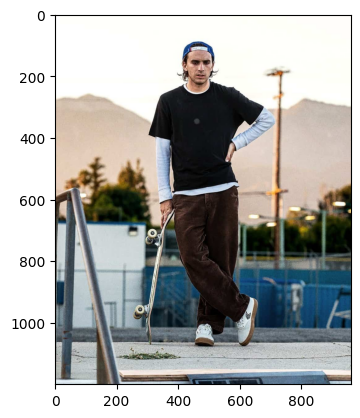

In [107]:
img_path = "test_images/img4.jpg"
plt.imshow(plt.imread(img_path))

img_64 = img_to_base64(img_path)
clothes = list_clothes(img_64)
clothes_df = json_to_dataframe(clothes, key='elements')
clothes_df

In [113]:
element = {"element":"Pants", "color":None, "fit":None, "price":None, "context":None, "description":None}
print(recommend_from_image(img_64, element=element))
print('\n')
print(recommend_from_wardrobe(clothes_df, element=element))

{"element": "Jeans",
 "color": "dark wash",
 "fit": "slim",
 "price": "80",
 "context": "casual",
 "description": "A pair of dark wash slim-fit jeans that would complement the existing casual and streetwear vibe of the outfit."}


{
  "element": "Chinos",
  "color": "Beige",
  "fit": "Slim",
  "price": 80,
  "context": "casual",
  "description": "A pair of slim-fit beige chinos would complement your wardrobe nicely. Following the 'complementary colors' rule, the beige will contrast well with the blue shades of your long-sleeve shirt and baseball cap. Additionally, the slim fit will provide a 'proportion balance' to your baggy corduroy pants, offering versatility for both casual and slightly more formal occasions."
}
